In [ ]:
# -----------------------------------------------------------------------------
# 5. OVERSAMPLING (BALANCEO DE CLASES)
# -----------------------------------------------------------------------------
from sklearn.utils import resample

# Solo aplicamos oversampling al conjunto de ENTRENAMIENTO
print("Distribución original en Train:")
print(train_df['label'].value_counts())

# Separar clases
df_0 = train_df[train_df.label == 0]
df_1 = train_df[train_df.label == 1]
df_2 = train_df[train_df.label == 2]

# Encontrar la clase mayoritaria
max_len = max(len(df_0), len(df_1), len(df_2))

# Oversampling de clases minoritarias
df_0_upsampled = resample(df_0, replace=True, n_samples=max_len, random_state=42)
df_1_upsampled = resample(df_1, replace=True, n_samples=max_len, random_state=42)
df_2_upsampled = resample(df_2, replace=True, n_samples=max_len, random_state=42)

# Combinar
train_df_balanced = pd.concat([df_0_upsampled, df_1_upsampled, df_2_upsampled])

# Mezclar
train_df = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nDistribución balanceada en Train:")
print(train_df['label'].value_counts())


Leeyendo datos desde: sent_train.csv
Aplicando limpieza de texto...
Total de registros válidos: 9537

Ejemplo de datos limpios:
                                                text  label
0  $BYND - JPMorgan reels in expectations on Beyo...      0
1  $CCL $RCL - Nomura points to bookings weakness...      0
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3                $ESS: BTIG Research cuts to Neutral      0
4    $FNKO - Funko slides after Piper Jaffray PT cut      0


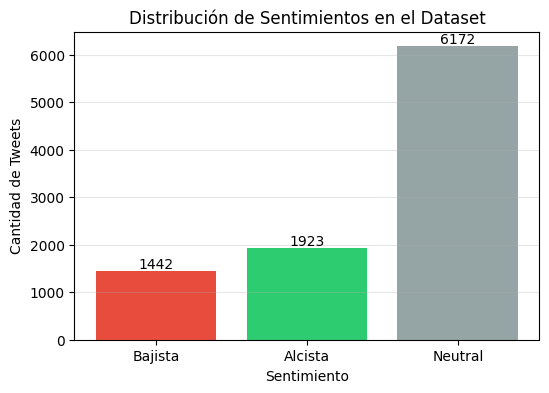


División realizada:
 - Train: 6675 (70.0%)
 - Val:   1430 (15.0%)
 - Test:  1432 (15.0%)

Construyendo vocabulario...
Tamaño final del vocabulario: 6295 tokens

¡Proceso completado! Archivos guardados en la carpeta 'data_processed/'


In [1]:
# =============================================================================
# NOTEBOOK 1: PREPARACIÓN DE DATOS Y VOCABULARIO
# =============================================================================

import pandas as pd
import numpy as np
import random
import pickle
import os
import re
from collections import Counter
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
SEED = 42
DATA_PATH = "sent_train.csv"  # CAMBIO: Usamos el dataset crudo
OUTPUT_DIR = "data_processed"

# Crear carpeta de salida si no existe
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Fijar semillas para reproducibilidad
random.seed(SEED)
np.random.seed(SEED)

print(f"Leeyendo datos desde: {DATA_PATH}")

# -----------------------------------------------------------------------------
# 1. CARGA Y LIMPIEZA INICIAL
# -----------------------------------------------------------------------------
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"No se encontró el archivo {DATA_PATH}. Por favor súbelo.")

df = pd.read_csv(DATA_PATH)

# Eliminar filas vacías
df = df.dropna(subset=["text", "label"]).reset_index(drop=True)

# Asegurar tipos de datos
df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(int)

# --- NUEVO: LIMPIEZA DE TEXTO ---
def clean_text(text):
    # 1. Eliminar URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # 2. Eliminar menciones de usuario (opcional: reemplazar por <USER>)
    text = re.sub(r'@\w+', '', text)
    # 3. Eliminar caracteres HTML (si los hubiera)
    text = re.sub(r'<.*?>', '', text)
    # 4. Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()
    return text

print("Aplicando limpieza de texto...")
df["text"] = df["text"].apply(clean_text)

# Eliminar tweets que quedaron vacíos tras la limpieza
df = df[df["text"].str.len() > 0].reset_index(drop=True)

print(f"Total de registros válidos: {len(df)}")
print("\nEjemplo de datos limpios:")
print(df.head())

# -----------------------------------------------------------------------------
# 2. ANÁLISIS EXPLORATORIO (EDA)
# -----------------------------------------------------------------------------
conteo_clases = df['label'].value_counts().sort_index()
labels_map = {0: 'Bajista', 1: 'Alcista', 2: 'Neutral'}

plt.figure(figsize=(6, 4))
bars = plt.bar(conteo_clases.index, conteo_clases.values, color=['#e74c3c', '#2ecc71', '#95a5a6'])
plt.xticks([0, 1, 2], [labels_map[0], labels_map[1], labels_map[2]])
plt.title("Distribución de Sentimientos en el Dataset")
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad de Tweets")
plt.grid(axis='y', alpha=0.3)

# Añadir etiquetas encima de las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')
plt.show()

# -----------------------------------------------------------------------------
# 3. DIVISIÓN DE DATOS (TRAIN / VAL / TEST)
# -----------------------------------------------------------------------------
# Mezclamos el dataset
df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

n_total = len(df)
n_train = int(0.70 * n_total)
n_val = int(0.15 * n_total)
# El resto (aprox 15%) será Test

train_df = df.iloc[:n_train].copy()
val_df = df.iloc[n_train : n_train + n_val].copy()
test_df = df.iloc[n_train + n_val:].copy()

print(f"\nDivisión realizada:")
print(f" - Train: {len(train_df)} ({len(train_df)/n_total:.1%})")
print(f" - Val:   {len(val_df)} ({len(val_df)/n_total:.1%})")
print(f" - Test:  {len(test_df)} ({len(test_df)/n_total:.1%})")

# -----------------------------------------------------------------------------
# 4. CREACIÓN DEL VOCABULARIO
# -----------------------------------------------------------------------------
def basic_tokenize(text: str):
    """Tokenizador simple: minúsculas y split por espacios."""
    return text.lower().split()

def build_vocab(texts, min_freq=2):
    """Crea vocabulario ignorando palabras poco frecuentes."""
    counter = Counter()
    for t in texts:
        counter.update(basic_tokenize(t))
    
    # Tokens especiales
    vocab = {"<PAD>": 0, "<UNK>": 1}
    idx = 2
    
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1
            
    return vocab

# IMPORTANTE: El vocabulario se crea SOLO con los datos de entrenamiento
print("\nConstruyendo vocabulario...")
vocab = build_vocab(train_df["text"].tolist(), min_freq=2)
print(f"Tamaño final del vocabulario: {len(vocab)} tokens")

# -----------------------------------------------------------------------------
# 5. GUARDADO DE ARTEFACTOS
# -----------------------------------------------------------------------------
# Guardamos los CSV procesados
train_df.to_csv(f"{OUTPUT_DIR}/train.csv", index=False)
val_df.to_csv(f"{OUTPUT_DIR}/val.csv", index=False)
test_df.to_csv(f"{OUTPUT_DIR}/test.csv", index=False)

# Guardamos el vocabulario como pickle
with open(f"{OUTPUT_DIR}/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

print(f"\n¡Proceso completado! Archivos guardados en la carpeta '{OUTPUT_DIR}/'")
